#### Imports

In [15]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import transform


#### Fonctions utilitaires pour parcourir les images

In [16]:
common_path = "./chest_Xray"
images_files = os.listdir(common_path)
subfolders = ["train","val","test"]
categories = ["NORMAL","PNEUMONIA"]

def browse_imgs(img_callback, path_folder_callback = None, limit_size = None):
    for subfolder in subfolders:
        for category in categories:
            folder_path = os.path.join(common_path, subfolder, category)
            images_files = os.listdir(folder_path)
            if path_folder_callback is not None:
                path_folder_callback(folder_path, images_files)
            array_limit = limit_size if limit_size is not None else len(images_files)
            for file_name in images_files[:array_limit]:
                if not file_name.endswith(".jpeg"):
                    continue
                image_path = os.path.join(folder_path,file_name)
                img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
                img_callback(img, category, file_name)  # Pass file_name as an additional argument
                
                
def display_imgs(imgs, titles = [], plot_size = (1,1), figsize = (10,8)):
    fig = plt.figure(figsize=figsize)
    index = 0
    for image, title in zip(imgs, titles):
        index += 1
        ax = fig.add_subplot(plot_size[0], plot_size[1], index) 
        ax.imshow(image, cmap="gray")
        ax.axis("off")
        if titles is not None:
            ax.set_title(title)

    plt.tight_layout()
    plt.show()

In [17]:
all_images = []
all_categories = []

datasetX = []
datasetY = []

image_size = (200, 200)

def load_datasets(img, category, file_name):
    if category == "PNEUMONIA":
        if "virus" in file_name:
            category = "VIRUS PNEUMONIA"
        elif "bacteria" in file_name:
            category = "BACTERIA PNEUMONIA"
    else:
        category = "NORMAL"
    
    new_img = cv2.resize(img, image_size)
    all_images.append(new_img)
    all_categories.append(category)

browse_imgs(load_datasets)

##### Doubler le dataset d'images NORMAL

In [7]:
# Définir une fonction pour effectuer une rotation d'image
def rotate_image(image, angle):
    return transform.rotate(image, angle)

# Définir une fonction pour effectuer un retournement horizontal d'image
def flip_image(image):
    return image[:, ::-1]

normal_indice = []
print("Normal indices size : ", len(normal_indice))

# Créer une liste pour stocker les indices des images "NORMAL"
normal_indice = [i for i, category in enumerate(all_categories) if category == "NORMAL"]

print("Normal indices size : ", len(normal_indice))

# Pour chaque image "NORMAL"...
for i in normal_indice:
    img = all_images[i]

    # Effectuer une rotation de 20 degrés, redimensionner l'image et l'ajouter à la liste de toutes les images
    rotated_img = rotate_image(img, 20)
    resized_rotated_img = cv2.resize(rotated_img, image_size)
    all_images.append(resized_rotated_img)
    all_categories.append("NORMAL")

    # Effectuer un retournement horizontal, redimensionner l'image et l'ajouter à la liste de toutes les images
    flipped_img = flip_image(img)
    resized_flipped_img = cv2.resize(flipped_img, image_size)
    all_images.append(resized_flipped_img)
    all_categories.append("NORMAL")

# Convert the list of all images to a numpy array
datasetX = np.array(all_images)

def use_all_dataset():
    global datasetX, datasetY
    datasetX = np.array(all_images)
    datasetY = np.array(all_categories)

use_all_dataset()
print("Dataset all shape : ", datasetX.shape)

Normal indices size :  0
Normal indices size :  1583
Dataset all shape :  (9022, 200, 200)
Dataset bp shape :  (3178, 200, 200)
Dataset ration shape :  (4431, 200, 200)
Dataset bp+ratio shape :  (2502, 200, 200)


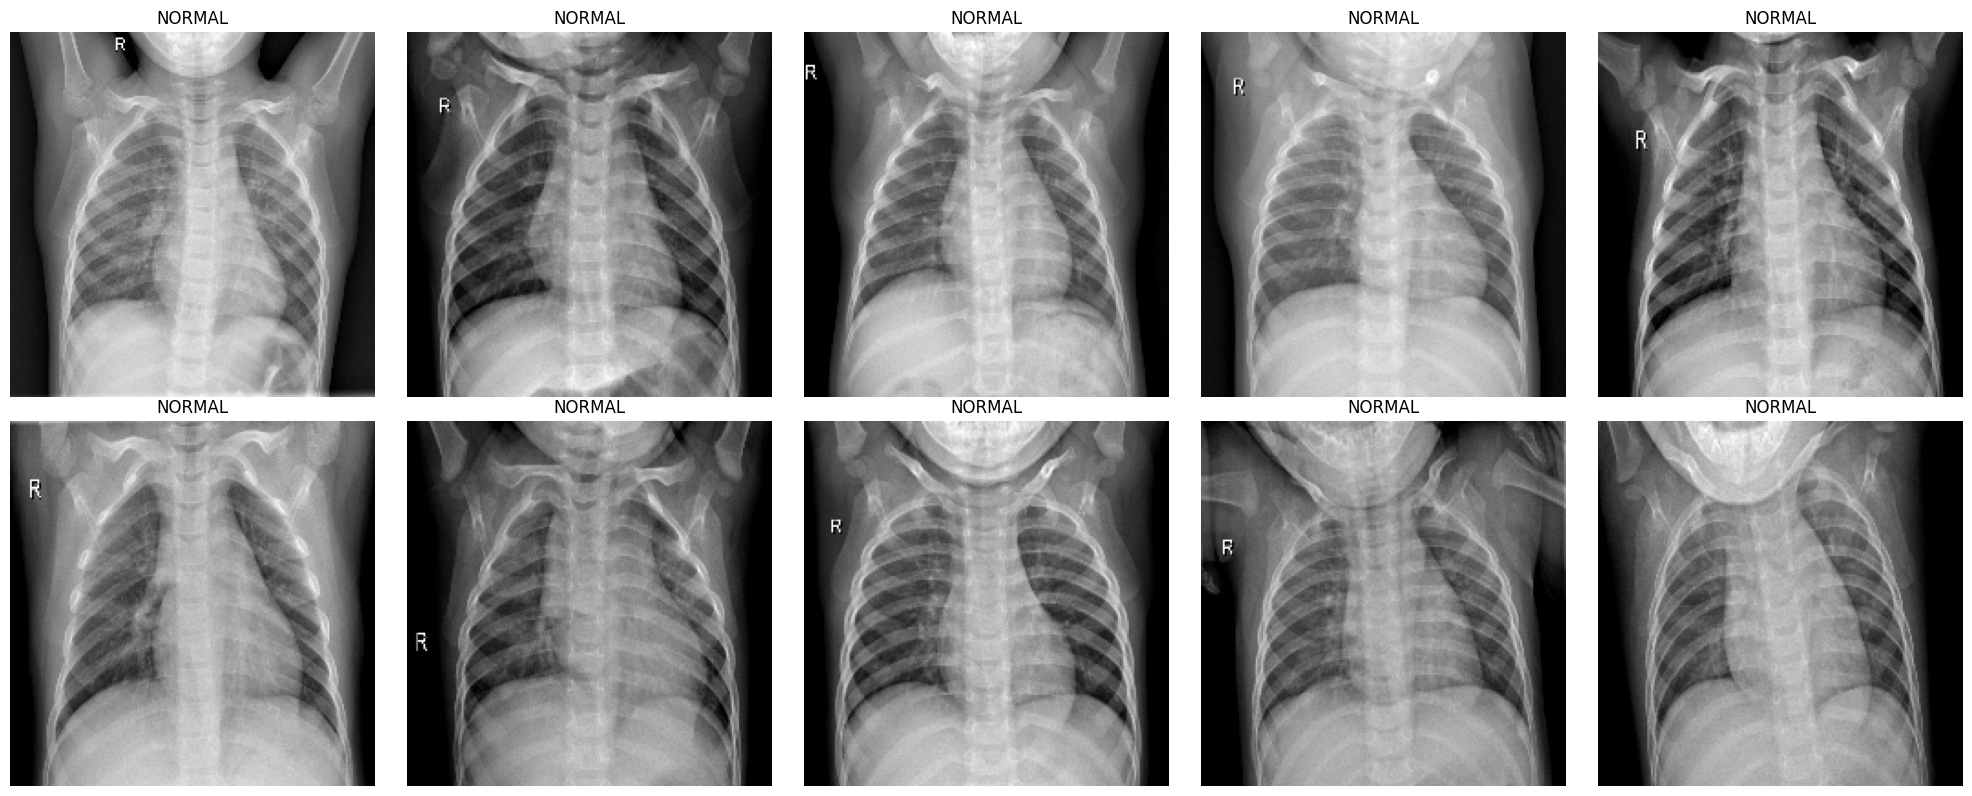

In [8]:
# Sélectionner les 5 premières images "NORMAL"
normal_images = [all_images[i] for i in normal_indice[:10]]

# Définir les titres pour les images
titles = ["NORMAL" for _ in range(10)]

# Utiliser la fonction display_imgs pour afficher les images
display_imgs(normal_images, titles, plot_size=(2, 5), figsize=(20,8))

#### Machine Learning

##### Resize and Flatten Transformers

In [ ]:
class ResizeImageTransformer():
    def __init__(self, size):
        self.size = size
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = np.array([cv2.resize(img, self.size) for img in X])
        return X

class FlattenTransformer():    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.reshape(len(X), -1)
        return X

In [ ]:
general_scoring = {
    "recall": make_scorer(recall_score, pos_label="PNEUMONIA"),
    "precision": make_scorer(precision_score, pos_label="PNEUMONIA"),
    "f1": make_scorer(f1_score, pos_label="PNEUMONIA")
}

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
import pandas as pd
from sklearn.model_selection import cross_validate

In [ ]:
def cross_val(model, load_dataset_function, scoring, nb_folds=3):
    load_dataset_function()
    res = cross_validate(model, datasetX, datasetY, cv=nb_folds, scoring=scoring, error_score="raise", return_train_score=True)
    res.pop("fit_time")
    res.pop("score_time")
    return res
    

def fit_and_score_each_dataset(model, scoring):
    res = {}
    
    res["all"] = (cross_val(model, use_all_dataset, scoring))
    
    return res

In [ ]:
model = make_pipeline(
    ResizeImageTransformer(size=(200,200)),
    FlattenTransformer(),
    KNeighborsClassifier(n_neighbors=11, weights='uniform', algorithm='auto')
)

scores = fit_and_score_each_dataset(model, general_scoring)
df = pd.DataFrame(scores)
df

In [ ]:
trainx, testx, trainy, testy = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
model.fit(trainx, trainy)

y_pred = model.predict(testx)

recall = recall_score(testy, y_pred, average='macro')
precision = precision_score(testy, y_pred, average='macro')
f1score = f1_score(testy, y_pred, average='macro')
print("Recall (macro) : ", recall)
print("Precision (macro) : ", precision)
print("F1 Score (macro) : ", f1score)

cm = confusion_matrix(testy, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

#### CNN - Convolution Neural Network

##### Les imports

In [13]:
import visualkeras as vk
import pandas as pd
# from scikeras.wrappers import KerasRegressor
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.utils import to_categorical

##### Le modèle

Convolution = mettre en évidence les caractéristiques de l'image.

Poolling = réduire l'image.

In [9]:
num_classes = 3
core_size = 2

model = tf.keras.Sequential([
    layers.Input(shape=(200, 200, 1)),
    layers.Conv2D(32, core_size, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, core_size, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, core_size, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, core_size, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# model.summary()

##### L'entrainement

In [10]:
# model.compile(optimizer='adam',
#               loss=tf.losses.BinaryCrossentropy(from_logits=False),
#               metrics=['recall', 'precision'])

# 2ème méthode de compilation qui permet de configurer des paramètres supplémentaires lors de l'instanciation
# si nécessaire
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [7]:
def display_distribution(ytrain, yval, testy):
    test = (np.count_nonzero(testy == "NORMAL"), np.count_nonzero(testy == "PNEUMONIA"))
    train = (np.count_nonzero(ytrain == "NORMAL"), np.count_nonzero(ytrain == "PNEUMONIA"))
    val = (np.count_nonzero(yval == "NORMAL"), np.count_nonzero(yval == "PNEUMONIA"))
    
    # Tracer les graphiques de distribution
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].bar(["NORMAL", "PNEUMONIA"], train)
    ax[0].set_title("Train Distribution")
    ax[1].bar(["NORMAL", "PNEUMONIA"], val)
    ax[1].set_title("Validation Distribution")
    ax[2].bar(["NORMAL", "PNEUMONIA"], test)
    ax[2].set_title("Test Distribution")
    plt.show()

In [14]:
# Convert the list of all images to a numpy array
datasetX = np.array(all_images)
datasetY = np.array(all_categories)

xtrain, otherX, ytrain, otherY = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
xval, testx, yval, testy = train_test_split(otherX, otherY, test_size=0.5, random_state=1)

xtrain = xtrain / 255
testx = testx / 255
xval = xval / 255

print(xtrain.shape)
print(testx.shape)
print(xval.shape)
# display_distribution(ytrain, yval, testy)

# Convert labels to numeric values
label_to_index = {"NO PNEUMONIA": 0, "VIRUS PNEUMONIA": 1, "BACTERIA PNEUMONIA": 2}
ytrain = np.array([label_to_index[y] for y in ytrain])
testy = np.array([label_to_index[y] for y in testy])
yval = np.array([label_to_index[y] for y in yval])

model.fit(xtrain,
    ytrain_one_hot,
    validation_data=(xval, yval_one_hot),
    epochs=2)

(4684, 200, 200)
(586, 200, 200)
(586, 200, 200)
Epoch 1/2


AttributeError: 'NoneType' object has no attribute 'items'

In [49]:
print(model.evaluate(testx, testy))

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.1050 - precision_4: 0.9250 - recall_4: 0.9789
[0.1058962270617485, 0.976190447807312, 0.9360730648040771]


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


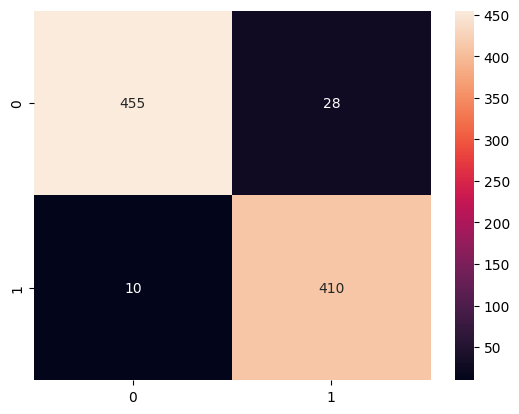

[[455  28]
 [ 10 410]]
recall :  0.9761904761904762
precision :  0.9360730593607306
f1score :  0.9557109557109557


In [50]:
y_pred = model.predict(testx)

y_pred_label = np.round(y_pred).astype(int)

cm = confusion_matrix(testy, y_pred_label)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

print(cm)
recall = recall_score(testy, y_pred_label)
precision = precision_score(testy, y_pred_label)
f1score = f1_score(testy, y_pred_label)
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

#### Tentative GridSearch

In [114]:
use_all_dataset()

trainx, otherX, trainy, otherY = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
xval, testx, yval, testy = train_test_split(otherX, otherY, test_size=0.5, random_state=1)

trainx = trainx / 255
print("xtrain normalized")
testx = testx / 255
xval = xval / 255

print(trainx.shape)
print(testx.shape)
print(xval.shape)

# For datasetY replace normal with 0 and pneumonia with 1 in order to have numeric values
trainy = np.array([0 if y == "NORMAL" else 1 for y in trainy])
testy = np.array([0 if y == "NORMAL" else 1 for y in testy])
yval = np.array([0 if y == "NORMAL" else 1 for y in yval])

xtrain normalized
(4684, 200, 200)
(586, 200, 200)
(586, 200, 200)


In [115]:
num_classes= 1
core_size = 4

def create_model(optimizer='adam'):
    model = tf.keras.Sequential([
        layers.Input(shape=(200, 200, 1)),
        layers.Conv2D(64, core_size, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, core_size, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(16, core_size, activation='relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(16, activation='relu'),
        layers.Dense(num_classes, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [117]:
model = KerasClassifier(build_fn=create_model, verbose=1)

print("model crée")

# define the grid search parameters
optimizer = ['Adadelta', 'Adam', 'Adamax']
param_grid = dict(optimizer=optimizer)

print("param grid défini")

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
print("fit va commencer")
grid_result = grid.fit(trainx, trainy)
print("fit done")

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

model crée
param grid défini
fit va commencer


KeyboardInterrupt: 

#### Validation curve core_size

In [84]:
use_all_dataset()

trainx, testx, trainy, testy = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
xtrain, xval, ytrain, yval = train_test_split(trainx, trainy, test_size=0.2, random_state=1)

xtrain = xtrain / 255
print("xtrain normalized")
testx = testx / 255
xval = xval / 255

print(trainx.shape)
print(testx.shape)
print(xval.shape)

# For datasetY replace normal with 0 and pneumonia with 1 in order to have numeric values
ytrain = np.array([0 if y == "NORMAL" else 1 for y in ytrain])
testy = np.array([0 if y == "NORMAL" else 1 for y in testy])
yval = np.array([0 if y == "NORMAL" else 1 for y in yval])

xtrain normalized
(4684, 200, 200)
(1172, 200, 200)
(937, 200, 200)


start validation_curve
Epoch 1/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 243ms/step - loss: 0.5753 - recall: 0.9270
Epoch 2/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - loss: 0.3303 - recall: 0.9676
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step
Epoch 1/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 242ms/step - loss: 0.5681 - recall: 0.9626
Epoch 2/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 251ms/step - loss: 0.3109 - recall: 0.9753
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step
Epoch 1/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 252ms/step - loss: 0.5327 - recall: 0.9888
Epoch 2/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 248ms/step - loss: 0.3217 - recall: 0.9679
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step
end validation_curve


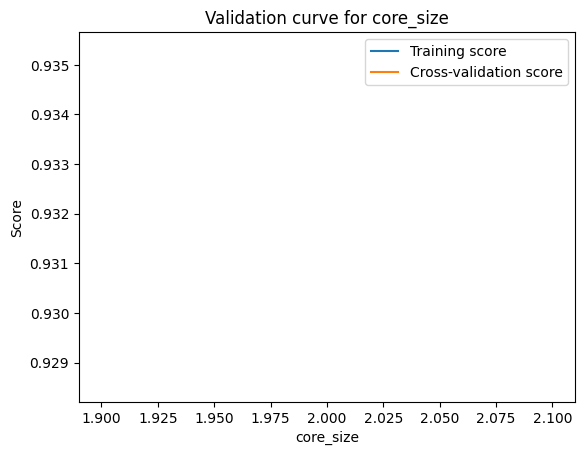

In [85]:
from sklearn.model_selection import validation_curve

# Define a function to create a model with a given core_size
def create_model(core_size):
    model = tf.keras.Sequential([
        layers.Input(shape=(200, 200, 1)),
        layers.Conv2D(64, core_size, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(62, core_size, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(16, core_size, activation='relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(16, activation='relu'),
        layers.Dense(num_classes, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['recall'])
    return model

# Wrap the model in a KerasClassifier
model = KerasClassifier(model=create_model, verbose=1, core_size=2, epochs=2)

# Define the range of core_sizes to evaluate
core_sizes = [2, 4, 6, 8]

print("start validation_curve")
# Compute the validation curve
train_scores, valid_scores = validation_curve(
    model, xtrain, ytrain, param_name="core_size", param_range=core_sizes, cv=3, scoring="recall"
)
print("end validation_curve")

plt.figure()
plt.plot(core_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(core_sizes, np.mean(valid_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for core_size')
plt.xlabel('core_size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

In [96]:
from sklearn.model_selection import cross_validate
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

# Define a function to create a model with a given core_size
def create_model(core_size):
    model = tf.keras.Sequential([
        layers.Input(shape=(200, 200, 1)),
        layers.Conv2D(64, core_size, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(62, core_size, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(16, core_size, activation='relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(16, activation='relu'),
        layers.Dense(num_classes, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['recall'])
    return model

# Define the range of core_sizes to evaluate
core_sizes = [2, 4, 6, 8]

# Initialize lists to store scores
train_scores = []
valid_scores = []

print("start cross_validate")
# Compute the validation curve
for core_size in core_sizes:
    # Wrap the model in a KerasClassifier with the current core_size
    model = KerasClassifier(build_fn=partial(create_model, core_size=core_size), verbose=1, epochs=2)
    scores = cross_validate(model, xtrain, ytrain, cv=3, scoring="recall", return_train_score=True)
    train_scores.append(scores['train_score'])
    valid_scores.append(scores['test_score'])
print("end cross_validate")

plt.figure()
plt.plot(core_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(core_sizes, np.mean(valid_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for core_size')
plt.xlabel('core_size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

#### Validation curve epoch

118/118 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - loss: 0.5630 - recall: 0.9976 - val_loss: 0.3436 - val_recall: 0.9688
Epoch 1/2
118/118 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - loss: 0.6064 - recall: 1.0000 - val_loss: 0.4985 - val_recall: 0.7054
Epoch 2/2
118/118 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - loss: 0.4818 - recall: 0.9427 - val_loss: 0.2464 - val_recall: 0.9449
Epoch 1/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 116s 977ms/step - loss: 0.5722 - recall: 0.9824 - val_loss: 0.3778 - val_recall: 0.9792
Epoch 2/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 777s 7s/step - loss: 0.2803 - recall: 0.9354 - val_loss: 0.2742 - val_recall: 0.9777
Epoch 3/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - loss: 0.2302 - recall: 0.9498 - val_loss: 0.2764 - val_recall: 0.8988
Epoch 1/4
118/118 ━━━━━━━━━━━━━━━━━━━━ 107s 886ms/step - loss: 0.6085 - recall: 0.9314 - val_loss: 0.4198 - val_recall: 0.9762
Epoch 2/4
118/118 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - loss: 0.3105 - recall: 0.9209 - val_loss: 0.2789 - val_recall: 0.9568
Epoch 3/4
11

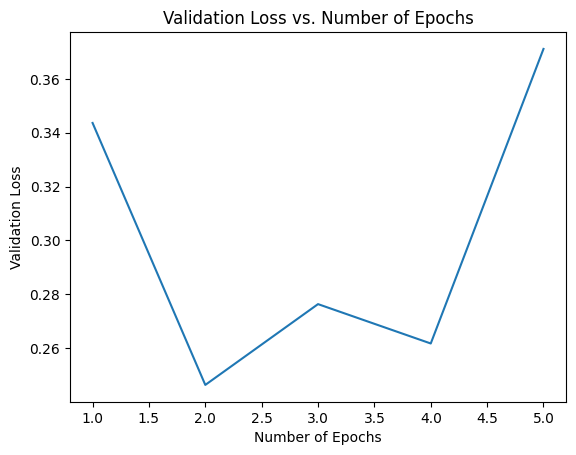

In [86]:
import matplotlib.pyplot as plt

# Liste pour stocker les scores de validation
val_scores = []
core_size = 8

# Liste des nombres d'epochs à tester
epochs_list = [1, 2, 3, 4, 5]

for epochs in epochs_list:
    # Créer un nouveau modèle pour chaque itération
    model = create_model(core_size)

    # Entraîner le modèle avec le nombre actuel d'epochs
    history = model.fit(xtrain, ytrain, validation_data=(xval, yval), epochs=epochs, verbose=1)

    # Obtenir le score de validation du dernier epoch et l'ajouter à la liste
    val_scores.append(history.history['val_loss'][-1])

# Tracer les scores de validation en fonction du nombre d'epochs
plt.plot(epochs_list, val_scores)
plt.xlabel('Number of Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs. Number of Epochs')
plt.show()

### Validation curve

In [ ]:
history = model.fit(xtrain,
                    ytrain,
                    validation_data=(xval, yval),
                    epochs=2)

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation precision
plt.figure(figsize=(12, 4))
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot the training and validation recall
plt.figure(figsize=(12, 4))
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()